# Sample crop and non-crop points from KAZA Landcover 2020

Important and useful links

- [KAZA Landcover 2020 Storymap](https://space-science.wwf.de/KAZAlandcover/)
- [KAZA Landcover 2020 Download](https://panda.maps.arcgis.com/home/item.html?id=0bd9f1902e4c4b9389d8c1f473c76d04) (there's also the link to the technical report)

Steps

- load and inspect 6 regions of interest shapefiles
- calculate relative areas and accordingly number of points to be sampled
- split large regions
- reproject crs
- load and inspect KAZA Landcover 2020 raster
- process raster: for each roi
    - clip raster to roi geometry and mask array
    - extract data from masked array
    - transform to dataframe
    - sample n crop and non-crop points (n proportional to area)
    - transform to geodataframe
- combine sampled points from all 6 regions of interest
- validate sampled points
- train test split and validate split
- save sampled points as csv and geojson

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import rasterio.mask
from rasterio import Affine
import geopandas as gpd
from shapely.geometry import Polygon
import json

In [2]:
%matplotlib inline

In [3]:
plt.style.use('seaborn-whitegrid')

In [4]:
positive_class = 40
samples_per_class = 1000

In [5]:
seed = 42

## Load and inspect 6 regions of interest shapefiles

In [6]:
roi_path = '../raw_data/aois_bengo'

In [7]:
binga = gpd.read_file(os.path.join(roi_path, 'Binga.shp'))[['geometry', 'area_km2']].assign(region='Binga')
hwange = gpd.read_file(os.path.join(roi_path, 'Hwange.shp'))[['geometry', 'area_km2']].assign(region='Hwange')
mufunta = gpd.read_file(os.path.join(roi_path, 'Mufunta.shp'))[['geometry', 'area_km2']].assign(region='Mufunta')
mulobesi = gpd.read_file(os.path.join(roi_path, 'Mulobesi.shp'))[['geometry', 'area_km2']].assign(region='Mulobesi')
sichifulo = gpd.read_file(os.path.join(roi_path, 'Sichifulo.shp'))[['geometry', 'area_km2']].assign(region='Sichifulo')
zambezi = gpd.read_file(os.path.join(roi_path, 'Zambezi.shp'))[['geometry', 'area_km2']].assign(region='Zambezi').to_crs(epsg=4326)

In [8]:
regions_of_interest = pd.concat([binga, hwange, mufunta, mulobesi, sichifulo, zambezi], axis=0).reset_index(drop=True)
regions_of_interest

,geometry,area_km2,region
0,"POLYGON ((28.03345 -17.00237, 28.03354 -17.002...",14794.00,Binga
1,"POLYGON ((25.28677 -17.80647, 25.28691 -17.806...",30607.30,Hwange
2,"POLYGON ((25.58421 -14.53576, 25.58513 -14.539...",6938.41,Mufunta
3,"POLYGON ((25.49953 -16.18899, 25.50866 -16.190...",3918.62,Mulobesi
4,"POLYGON ((25.63143 -16.64816, 25.63567 -16.648...",3893.37,Sichifulo
5,"POLYGON ((24.42817 -17.47902, 24.43599 -17.479...",18939.10,Zambezi


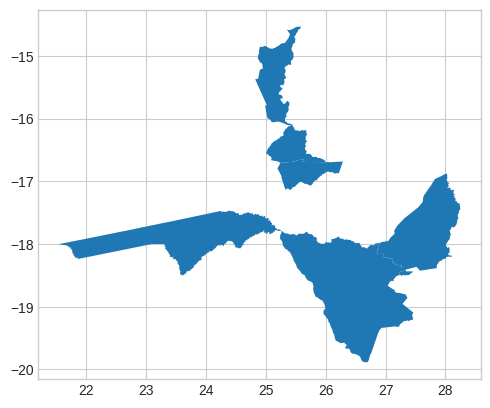

In [9]:
regions_of_interest.plot()
plt.show()

In [10]:
pd.concat([regions_of_interest['region'], regions_of_interest.bounds], axis=1)

,region,minx,miny,maxx,maxy
0,Binga,26.852225,-18.507756,28.251824,-16.876580
1,Hwange,25.237597,-19.888198,27.468296,-17.790122
2,Mufunta,24.824622,-16.108776,25.586628,-14.529700
3,Mulobesi,25.005018,-16.710792,26.005629,-16.093337
4,Sichifulo,25.196874,-17.137019,26.288657,-16.647680
5,Zambezi,21.541877,-18.501837,25.263637,-17.469283


### Calculate number of samples per region based on relative area

In [11]:
total_area = regions_of_interest['area_km2'].sum()
regions_of_interest['relative_area'] = regions_of_interest['area_km2'] / total_area
regions_of_interest['samples_per_class'] = round(regions_of_interest['relative_area'] * samples_per_class, 0).astype(np.uint32)
regions_of_interest

,geometry,area_km2,region,relative_area,samples_per_class
0,"POLYGON ((28.03345 -17.00237, 28.03354 -17.002...",14794.00,Binga,0.187051,187
1,"POLYGON ((25.28677 -17.80647, 25.28691 -17.806...",30607.30,Hwange,0.386989,387
2,"POLYGON ((25.58421 -14.53576, 25.58513 -14.539...",6938.41,Mufunta,0.087727,88
3,"POLYGON ((25.49953 -16.18899, 25.50866 -16.190...",3918.62,Mulobesi,0.049546,50
4,"POLYGON ((25.63143 -16.64816, 25.63567 -16.648...",3893.37,Sichifulo,0.049227,49
5,"POLYGON ((24.42817 -17.47902, 24.43599 -17.479...",18939.10,Zambezi,0.239460,239


### Split large regions

In [12]:
def split_large_regions(polygon, region_geodataframe, region_name, total_area, samples_per_class):
    
    polygon_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=region_geodataframe.crs)
    
    west = region_geodataframe[region_geodataframe['region'] == region_name].clip(polygon_gdf)
    east = region_geodataframe[region_geodataframe['region'] == region_name].difference(west)
    
    region_area_original = region_geodataframe[region_geodataframe['region'] == region_name]['area_km2'][1]    
    region_area_calculated = (region_geodataframe[region_geodataframe['region'] == region_name].to_crs({'proj':'cea'}).area / 10**6)[1]
    west_area = (west.to_crs({'proj':'cea'}).area / 10**6)[1]
    east_area = (east.to_crs({'proj':'cea'}).area / 10**6)[1]
    
    data = {'region': [region_name + '_West', region_name + '_East'],
            'area_km2': [(west_area / region_area_calculated) * region_area_original, (east_area / region_area_calculated) * region_area_original],
            'relative_area': [np.nan, np.nan],
            'samples_per_class': [np.nan, np.nan],
            'geometry': [west['geometry'][1], east[1]]}
    
    west_east = gpd.GeoDataFrame(data)
    
    west_east['relative_area'] = west_east['area_km2'] / total_area
    west_east['samples_per_class'] = round(west_east['relative_area'] * samples_per_class, 0).astype(np.uint32)
    west_east['area_km2'] = round(west_east['area_km2'], 2)
    
    return west_east

In [13]:
hwange_split_polygon = Polygon([(25, -20), (25, -17.5), (26.5, -17.5), (26.5, -20), (25, -20)])
hwange_split = split_large_regions(hwange_split_polygon, regions_of_interest, 'Hwange', total_area, samples_per_class)
hwange_split

,region,area_km2,relative_area,samples_per_class,geometry
0,Hwange_West,16478.48,0.208349,208,"POLYGON ((25.28691 -17.80660, 25.28704 -17.806..."
1,Hwange_East,14128.82,0.178640,179,"POLYGON ((26.50004 -17.98351, 26.50019 -17.983..."


In [14]:
regions_of_interest = pd.concat([regions_of_interest, hwange_split], axis=0).reset_index(drop=True)
regions_of_interest

,geometry,area_km2,region,relative_area,samples_per_class
0,"POLYGON ((28.03345 -17.00237, 28.03354 -17.002...",14794.00,Binga,0.187051,187
1,"POLYGON ((25.28677 -17.80647, 25.28691 -17.806...",30607.30,Hwange,0.386989,387
2,"POLYGON ((25.58421 -14.53576, 25.58513 -14.539...",6938.41,Mufunta,0.087727,88
3,"POLYGON ((25.49953 -16.18899, 25.50866 -16.190...",3918.62,Mulobesi,0.049546,50
4,"POLYGON ((25.63143 -16.64816, 25.63567 -16.648...",3893.37,Sichifulo,0.049227,49
5,"POLYGON ((24.42817 -17.47902, 24.43599 -17.479...",18939.10,Zambezi,0.239460,239
6,"POLYGON ((25.28691 -17.80660, 25.28704 -17.806...",16478.48,Hwange_West,0.208349,208
7,"POLYGON ((26.50004 -17.98351, 26.50019 -17.983...",14128.82,Hwange_East,0.178640,179


In [15]:
regions_of_interest = regions_of_interest.to_crs(epsg=32734)

## Load and inspect KAZA Landcover 2020 raster

In [16]:
raster_path = '../raw_data/kaza_landcover_2020'
raster_file = 'Land_Cover_KAZA_2021_TFCA.tif'
raster_file_path = os.path.join(raster_path, raster_file)
raster_file_path

'../raw_data/kaza_landcover_2020/Land_Cover_KAZA_2021_TFCA.tif'

In [17]:
kaza_landcover_2020 = rasterio.open(raster_file_path)

In [18]:
kaza_landcover_2020.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 117266,
 'height': 92929,
 'count': 1,
 'crs': CRS.from_epsg(32734),
 'transform': Affine(10.0, 0.0, 226890.268299328,
        0.0, -10.0, 8550840.20908763)}

In [19]:
kaza_landcover_2020.bounds

BoundingBox(left=226890.268299328, bottom=7621550.209087631, right=1399550.268299328, top=8550840.20908763)

## Clip raster, extract data and sample points

[Inspiration](https://gis.stackexchange.com/questions/384954/cutting-a-polygon-from-tiff-with-python)

In [20]:
def clip_raster(raster_file_path, region_geodataframe, region_name):
    
    region_index = region_geodataframe[region_geodataframe['region'] == region_name].index[0]

    with rasterio.open(raster_file_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, [region_geodataframe.loc[region_index]['geometry']], crop=True)
        out_meta = src.meta

        out_meta.update(
            {
                'height': out_image.shape[1],
                'width': out_image.shape[2],
                'transform': out_transform,
            }
        )
        
        out_file_path = raster_file_path.replace(raster_file_path.split('/')[-1], '')
        out_file_name = region_name.lower() + '.tif'

        with rasterio.open(os.path.join(out_file_path, out_file_name), 'w', **out_meta) as dest:
            dest.write(out_image)
    
    return out_transform

[Inspiration](https://gis.stackexchange.com/questions/260304/extract-raster-values-within-shapefile-with-pygeoprocessing-or-gdal)

In [21]:
def extract_data_from_raster(raster_file_path):
    
    raster = rasterio.open(raster_file_path)    
    masked_array = raster.read(1, masked=True)
    
    no_data = raster.nodata    
    data = masked_array.data
    
    row, col = np.where(data != no_data)
    landcover_class = np.extract(data != no_data, data)
    
    dataframe = pd.DataFrame({'col': col, 'row': row, 'landcover_class': landcover_class})
    
    return dataframe

In [22]:
def sample_points(points_dataframe, regions_dataframe, region_name, positive_class):
    
    n = regions_dataframe[regions_dataframe['region'] == region_name]['samples_per_class'].values
    
    samples_positive_class = points_dataframe[points_dataframe['landcover_class'] == positive_class].sample(n, random_state=seed)    
    samples_negative_class = points_dataframe[points_dataframe['landcover_class'] != positive_class].sample(n, random_state=seed)
    
    all_samples = pd.concat([samples_positive_class, samples_negative_class], axis=0).reset_index(drop=True)
    all_samples['region'] = region_name
    
    return all_samples

In [23]:
def make_geodataframe(dataframe, out_transform):
    
    T1 = out_transform * Affine.translation(0.5, 0.5)
    rc2xy = lambda r, c: (c, r) * T1
    
    dataframe['x'] = dataframe.apply(lambda row: rc2xy(row.row, row.col)[0], axis=1)
    dataframe['y'] = dataframe.apply(lambda row: rc2xy(row.row, row.col)[1], axis=1)
    
    geodataframe = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe.x, dataframe.y))
    
    return geodataframe

In [24]:
regions = regions_of_interest[regions_of_interest['region'] != 'Hwange']['region'].unique()
regions

array(['Binga', 'Mufunta', 'Mulobesi', 'Sichifulo', 'Zambezi',
       'Hwange_West', 'Hwange_East'], dtype=object)

In [25]:
%%time

sampled_points_per_region = pd.DataFrame()

for region in regions:
    
    print('Processing {}...'.format(region))
    
    print('    Clipping raster...')
    out_transform = clip_raster(raster_file_path, regions_of_interest, region)
    
    print('    Extracting data...')
    df = extract_data_from_raster(os.path.join(raster_path, region.lower() + '.tif'))
    
    print('    Sampling points...')
    samples = sample_points(df, regions_of_interest, region, positive_class)
    
    print('    Making geodataframe...')
    samples_gdf = make_geodataframe(samples, out_transform)
    
    sampled_points_per_region = pd.concat([sampled_points_per_region, samples_gdf], axis=0)

Processing Binga...
    Clipping raster...
    Extracting data...
    Sampling points...
    Making geodataframe...
Processing Mufunta...
    Clipping raster...


/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Sampling points...
    Making geodataframe...
Processing Mulobesi...
    Clipping raster...


/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Sampling points...
    Making geodataframe...
Processing Sichifulo...
    Clipping raster...


/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Sampling points...
    Making geodataframe...
Processing Zambezi...
    Clipping raster...


/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Sampling points...
    Making geodataframe...
Processing Hwange_West...
    Clipping raster...


/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Sampling points...
    Making geodataframe...
Processing Hwange_East...
    Clipping raster...


/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


    Extracting data...
    Sampling points...
    Making geodataframe...
CPU times: user 2min 1s, sys: 23.8 s, total: 2min 24s
Wall time: 2min 25s


/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1
/tmp/ipykernel_7008/1141624027.py:4: DeprecationWarning: Right multiplication will be prohibited in version 3.0
  rc2xy = lambda r, c: (c, r) * T1


## Validate sampled points

In [26]:
sampled_points_per_region = sampled_points_per_region.reset_index(drop=True)
sampled_points_per_region = sampled_points_per_region.drop(['col', 'row', 'x', 'y'], axis=1)

In [27]:
sampled_points_per_region = sampled_points_per_region.set_crs(epsg=32734)
sampled_points_per_region = sampled_points_per_region.to_crs(epsg=4326)

In [28]:
sampled_points_per_region

,landcover_class,region,geometry
0,40,Binga,POINT (27.51612 -18.04621)
1,40,Binga,POINT (27.29007 -18.12874)
2,40,Binga,POINT (27.59496 -18.31017)
3,40,Binga,POINT (27.14252 -17.91986)
4,40,Binga,POINT (27.25322 -18.12967)
...,...,...,...
1995,130,Hwange_East,POINT (26.89006 -19.01622)
1996,210,Hwange_East,POINT (26.83723 -19.00468)
1997,210,Hwange_East,POINT (26.54039 -19.04913)
1998,232,Hwange_East,POINT (26.75330 -18.03721)


In [29]:
landcover_mapping = pd.read_csv(os.path.join(raster_path, 'eoss4wwf_kaza_landcover_Aux/eoss4wwf_kaza_landcover_scheme.csv'), usecols=['code', 'class'])
landcover_mapping

,code,class
0,31,Open Herbaceous Vegetation
1,32,Open Herbaceous/Floodplain
2,40,Cropland
3,50,Built-up
4,60,Bare Area
5,61,Bare Floodplain Area
6,80,Water Bodies Permanent
7,81,Water Bodies Seasonal
8,90,Closed Herbaceous Wetland
9,91,Sparse Herbaceous Wetland


In [30]:
sampled_points_per_region = pd.merge(sampled_points_per_region, landcover_mapping, how='inner', left_on='landcover_class', right_on='code')
sampled_points_per_region = sampled_points_per_region.drop('code', axis=1)
sampled_points_per_region

,landcover_class,region,geometry,class
0,40,Binga,POINT (27.51612 -18.04621),Cropland
1,40,Binga,POINT (27.29007 -18.12874),Cropland
2,40,Binga,POINT (27.59496 -18.31017),Cropland
3,40,Binga,POINT (27.14252 -17.91986),Cropland
4,40,Binga,POINT (27.25322 -18.12967),Cropland
...,...,...,...,...
1995,91,Zambezi,POINT (23.56945 -18.28920),Sparse Herbaceous Wetland
1996,91,Zambezi,POINT (24.01158 -18.15355),Sparse Herbaceous Wetland
1997,91,Zambezi,POINT (24.95271 -17.63727),Sparse Herbaceous Wetland
1998,91,Zambezi,POINT (24.97588 -17.62119),Sparse Herbaceous Wetland


In [31]:
negative_class_landcover_frequencies = sampled_points_per_region[sampled_points_per_region['landcover_class'] != positive_class]['class'].value_counts().sort_values(ascending=True)
negative_class_landcover_frequencies

Sparse Herbaceous Wetland        9
Open Herbaceous/Floodplain      10
Water Bodies Seasonal           16
Open Herbaceous Vegetation      17
Open Herbaceous Wetland         18
Water Bodies Permanent          20
Closed Woodland                 50
Open Woodland/Bushland          73
Closed Bushland                111
Open Bushland/Shrubs           165
Sparse Forest/Woodland         227
Sparse/Open Bushland/Shrubs    284
Name: class, dtype: int64

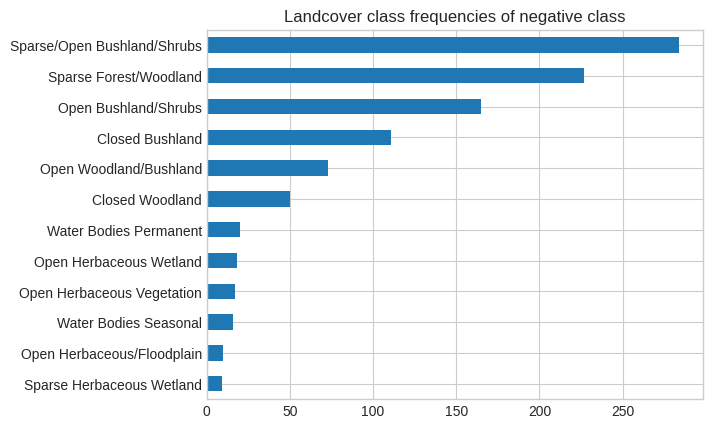

In [32]:
negative_class_landcover_frequencies.plot.barh(title='Landcover class frequencies of negative class')
plt.show()

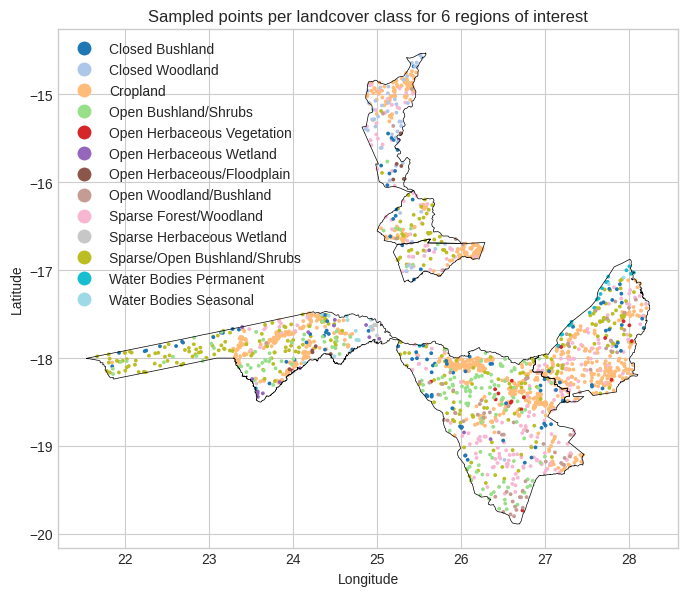

In [33]:
fig, ax = plt.subplots(figsize=(8,8))

regions_of_interest[~regions_of_interest['region'].isin(['Hwange_West', 'Hwange_East'])].exterior.to_crs(epsg=4326).plot(ax=ax, edgecolor='black', linewidth=0.5)

sampled_points_per_region.plot(ax=ax, column='class', markersize=3, categorical=True, legend=True, label='class', cmap='tab20')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Sampled points per landcover class for 6 regions of interest')

plt.show()

## Train test split

In [34]:
sampled_points_per_region = sampled_points_per_region.sample(frac=1, random_state=seed).reset_index(drop=True)
sampled_points_per_region['subset'] = ['train'] * int(len(sampled_points_per_region) * 0.8) + ['test'] * int(len(sampled_points_per_region) * 0.2)
sampled_points_per_region

,landcover_class,region,geometry,class,subset
0,231,Hwange_West,POINT (26.27313 -18.67769),Open Woodland/Bushland,train
1,40,Sichifulo,POINT (26.22911 -16.78453),Cropland,train
2,222,Zambezi,POINT (23.91473 -17.64923),Sparse/Open Bushland/Shrubs,train
3,40,Hwange_East,POINT (26.88519 -18.55946),Cropland,train
4,222,Mufunta,POINT (25.05245 -15.19111),Sparse/Open Bushland/Shrubs,train
...,...,...,...,...,...
1995,210,Hwange_West,POINT (26.22830 -18.89666),Sparse Forest/Woodland,test
1996,222,Mulobesi,POINT (25.44007 -16.37118),Sparse/Open Bushland/Shrubs,test
1997,40,Hwange_East,POINT (27.43635 -19.18086),Cropland,test
1998,222,Hwange_West,POINT (25.81123 -17.89990),Sparse/Open Bushland/Shrubs,test


In [35]:
sampled_points_per_region['subset'].value_counts()

train    1600
test      400
Name: subset, dtype: int64

In [36]:
sampled_points_per_region[sampled_points_per_region['landcover_class'] == positive_class]['subset'].value_counts()

train    818
test     182
Name: subset, dtype: int64

In [37]:
sampled_points_per_region[sampled_points_per_region['landcover_class'] != positive_class]['subset'].value_counts()

train    782
test     218
Name: subset, dtype: int64

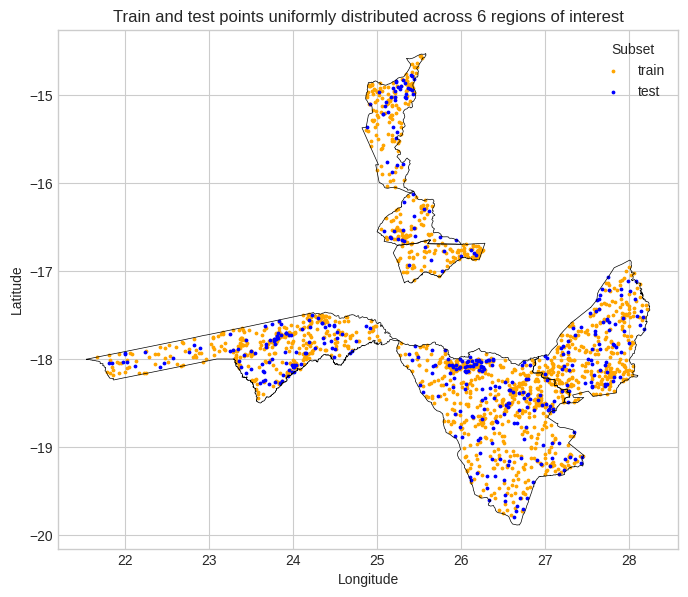

In [38]:
fig, ax = plt.subplots(figsize=(8,8))

regions_of_interest[~regions_of_interest['region'].isin(['Hwange_West', 'Hwange_East'])].exterior.to_crs(epsg=4326).plot(ax=ax, edgecolor='black', linewidth=0.5)

sampled_points_per_region[sampled_points_per_region['subset'] == 'train'].plot(ax=ax, markersize=3, color='orange', label='train')
sampled_points_per_region[sampled_points_per_region['subset'] == 'test'].plot(ax=ax, markersize=3, color='blue', label='test')

plt.legend(title='Subset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Train and test points uniformly distributed across 6 regions of interest')

plt.show()

## Save labels

In [39]:
sampled_points_per_region['crop'] = sampled_points_per_region['landcover_class'].apply(lambda x: 1 if x == positive_class else 0)
sampled_points_per_region['lat'] = sampled_points_per_region['geometry'].y
sampled_points_per_region['lon'] = sampled_points_per_region['geometry'].x
labels = sampled_points_per_region[['lat', 'lon', 'crop', 'subset']].copy()
labels

,lat,lon,crop,subset
0,-18.677686,26.273130,0,train
1,-16.784527,26.229109,1,train
2,-17.649228,23.914734,0,train
3,-18.559455,26.885187,1,train
4,-15.191106,25.052454,0,train
...,...,...,...,...
1995,-18.896664,26.228298,0,test
1996,-16.371185,25.440068,0,test
1997,-19.180858,27.436347,1,test
1998,-17.899901,25.811227,0,test


In [40]:
labels_file_path = '../processed_data'
labels_file_name = 'kaza_bengo_crop_2020'

### CSV

In [41]:
labels.to_csv(os.path.join(labels_file_path, '{}.csv'.format(labels_file_name)), index=False)

### GeoJSON

[Inspiration](https://stackoverflow.com/questions/60382659/generate-geojson-using-pandas-datframe)

In [42]:
geojson = {'type': 'FeatureCollection', 'features': []}

for _, row in labels.iterrows():
    feature = {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [row['lon'], row['lat']]}, 'properties': {'crop': row['crop'], 'subset': row['subset']}}
    geojson['features'].append(feature)

with open(os.path.join(labels_file_path, '{}.geojson'.format(labels_file_name)), 'w') as fp:
    json.dump(geojson, fp)

In [43]:
# make sure geojson was saved corretly
test_geojson = gpd.read_file(os.path.join(labels_file_path, '{}.geojson'.format(labels_file_name)))
test_geojson

,crop,subset,geometry
0,0,train,POINT (26.27313 -18.67769)
1,1,train,POINT (26.22911 -16.78453)
2,0,train,POINT (23.91473 -17.64923)
3,1,train,POINT (26.88519 -18.55946)
4,0,train,POINT (25.05245 -15.19111)
...,...,...,...
1995,0,test,POINT (26.22830 -18.89666)
1996,0,test,POINT (25.44007 -16.37118)
1997,1,test,POINT (27.43635 -19.18086)
1998,0,test,POINT (25.81123 -17.89990)
